In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

%load_ext autoreload
%autoreload 2
%matplotlib inline

warnings.filterwarnings('ignore')

# Load data
ust_futures = pd.read_csv('raw_futures_prices.csv', index_col=0, parse_dates=[0]).dropna(how='any', axis=0)

# Potential pairs.
pairs = list(combinations(ust_futures.columns, 2))

# Define spreads

In [3]:
from collections import defaultdict
from more_itertools import windowed

import v2.copulas.fitting as fitting
import v2.backtest.hedging as hedging
import v2.backtest.signal_ as signal_

# PnL analysis for each pair.
yearly_copulas = {}

# Make a list of years.
years = ['2018', '2019', '2020', '2021', '2022']
years_windowed = list(windowed(years, 3))

for train_start, train_end, test_end in years_windowed:
    # Fit the copulas -- index by trading year for the
    # dictionary.
    yearly_signal_obj = signal_.SignalGeneration(ust_futures, pairs, train_start, train_end, test_end, test_end,copula_type='mixed')
    yearly_copulas[test_end] = yearly_signal_obj

In [4]:
import backtest.backtester as backtest

prep_backtest = {}

for year, signal_obj in yearly_copulas.items():
    prices = signal_obj.prices
    sigs = signal_obj.calc_signals()
    prices = prices.loc[year]
    for col in sigs.columns:
        prices[col] = signal_obj.generate_signals(sigs[col]).values

    prep_backtest[year]= prices.copy()

In [8]:
# Run backtest

yearly_agg_results = {}
yearly_agg_returns = {}

for year in ['2020', '2021', '2022']:
    agg_results = pd.DataFrame()

    for pair in pairs:
        train_data = yearly_copulas[year].prices[[pair[0], pair[1]]]
        pair_data = prep_backtest[year][[pair[0], pair[1], pair]]
        pair_data = pair_data.rename({pair: 'Signal'}, axis=1)
        pair_data['Betas'] = 1
        res = backtest.backtest(pair_data)
        agg_results[pair] = res['Total PnL']

    agg_returns = (10_000 + agg_results).pct_change().dropna()
    agg_results = (1 + (agg_results + 10_000).pct_change().dropna()).cumprod() - 1
    yearly_agg_results[year] = agg_results
    yearly_agg_returns[year] = agg_returns

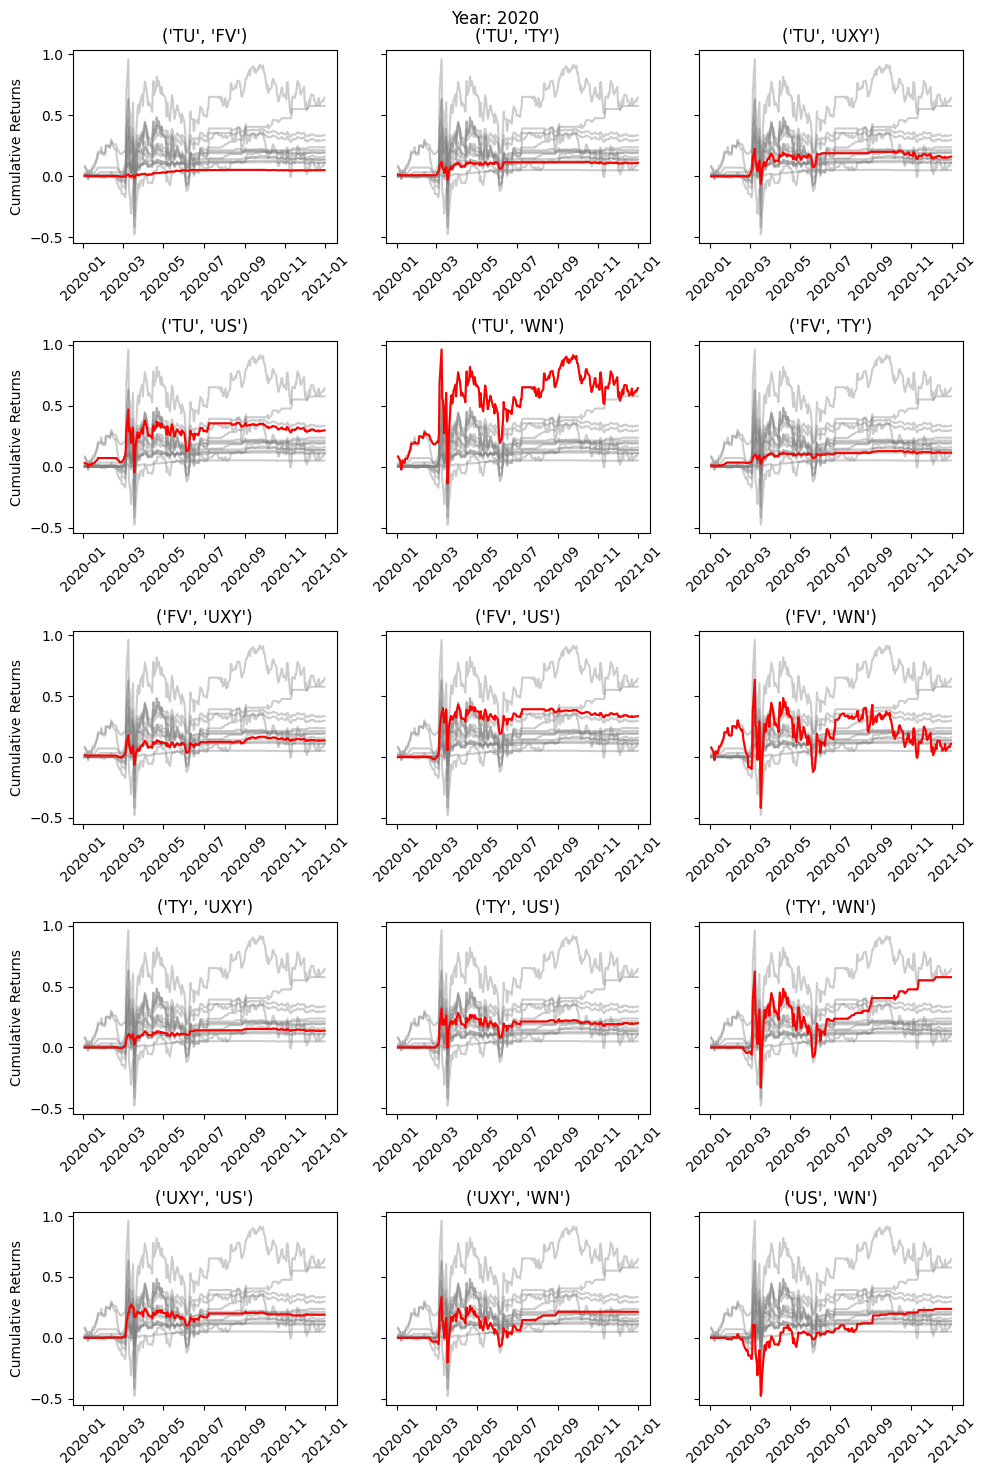

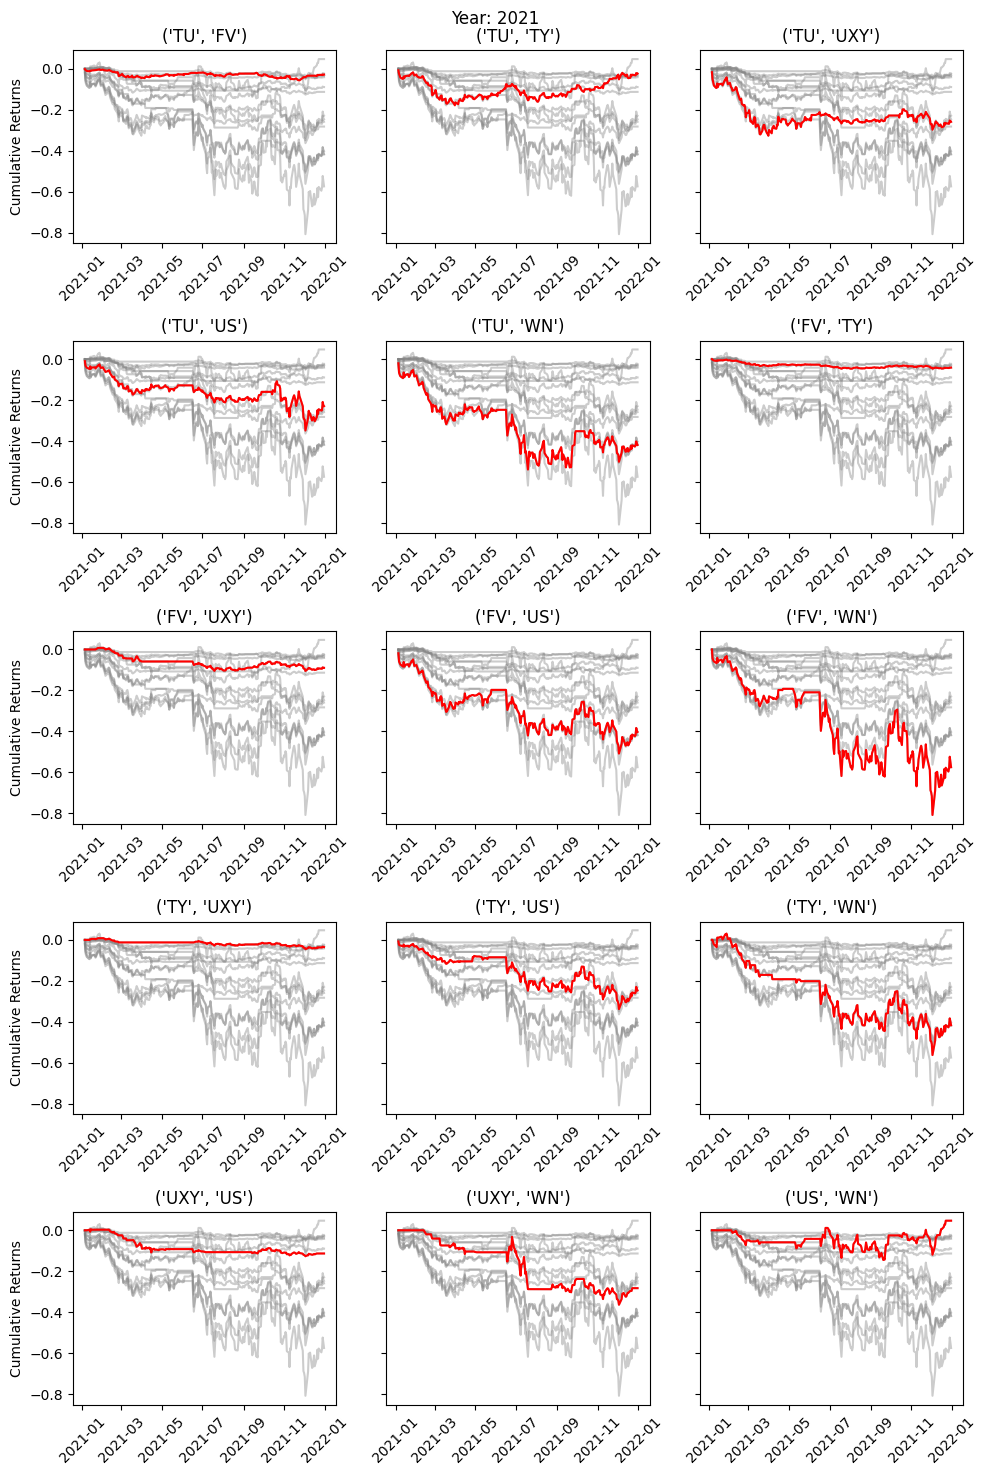

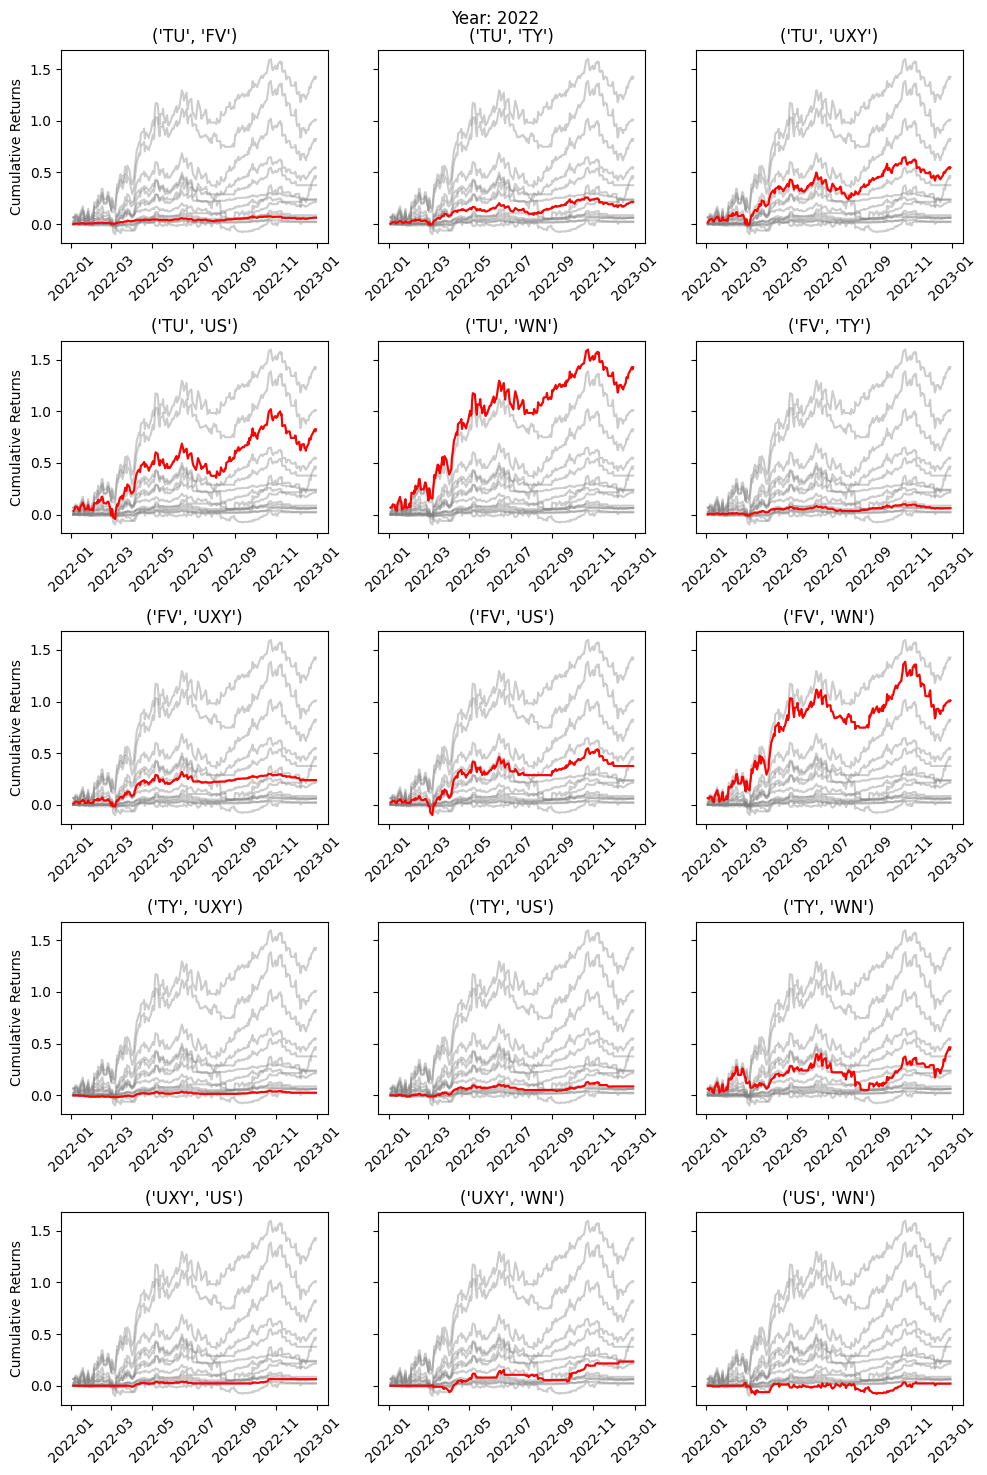

In [41]:
# Plot results

for year, agg_results in yearly_agg_results.items():
    cols = agg_results.columns

    # Make 5x3 subplots, and make them share an x-axis.
    fig, axs = plt.subplots(5, 3, sharey=True, figsize=(10, 15))

    for i in range(5):
        for j in range(3):
            axs[i, j].plot(agg_results, alpha=0.4, color='grey')
            axs[i, j].plot(agg_results[cols[i*3 + j]], color='red')
            axs[i, j].set_title(cols[i*3 + j])
            plt.setp(axs[i, j].get_xticklabels(), rotation=45)

            # Set y label
            if j == 0:
                axs[i, j].set_ylabel('Cumulative Returns')
            else:
                axs[i, j].set_ylabel('')

    # Adjust the spacing between subplots.
    plt.subplots_adjust(hspace=0.5)
    plt.subplots_adjust(wspace=0.5)


    fig.suptitle(f"Year: {year}")
    plt.tight_layout()
    plt.show()

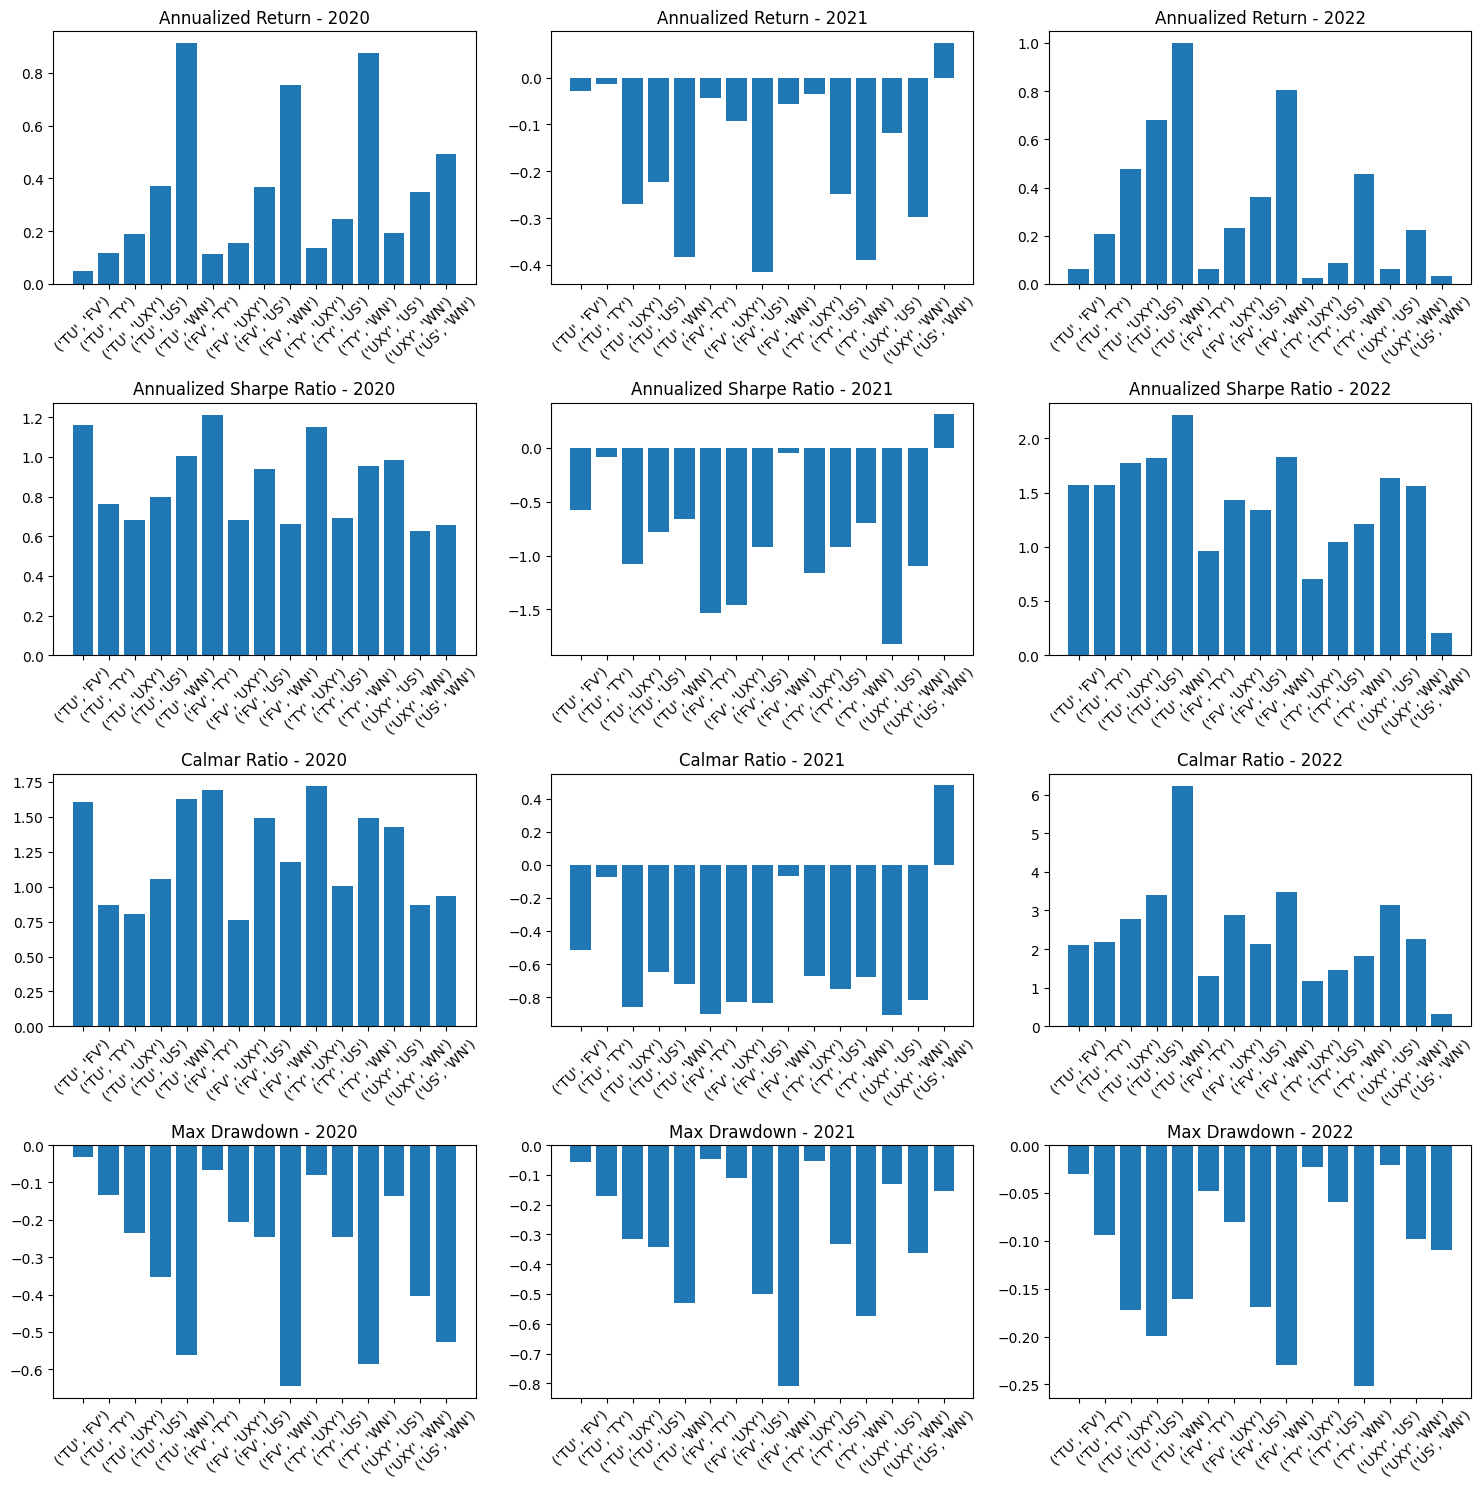

In [32]:
from analysis.performance import perf_summ

fig, axs = plt.subplots(4, 3, figsize=(15, 15))

# Plot the bar charts.
for idx, stat in enumerate(["Annualized Return", "Annualized Sharpe Ratio", "Calmar Ratio", "Max Drawdown"]):
    for j in range(3):
        # Get the year.
        year = str(2020 + j)
        summ = perf_summ(yearly_agg_returns[year], adj=252)
        labels = [str(i[0]) + ' ' + str(i[1]) for i in summ.index]
        axs[idx, j].bar(labels, summ[stat])
        axs[idx, j].set_title(f'{stat} - {year}')
        axs[idx, j].set_xticklabels(summ.index, rotation=45)

plt.tight_layout()
plt.show()

In [33]:
for year, agg_results in yearly_agg_returns.items():
    print(f"Year: {year}")
    display(perf_summ(agg_results, adj=252))
    print()

Year: 2020


,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Calmar Ratio,Peak,Bottom,Recovery
"(TU, FV)",0.050614,0.043524,1.162910,1.044437,0.189498,11.268199,-0.002699,-0.006389,-0.014447,0.012645,-0.031586,1.602424,2020-03-09,2020-03-18,2020-03-23 00:00:00
"(TU, TY)",0.115879,0.152011,0.762307,0.686420,-0.054350,13.027314,-0.009403,-0.023227,-0.051529,0.048215,-0.133574,0.867525,2020-03-09,2020-03-18,Not yet recovered
"(TU, UXY)",0.189630,0.278543,0.680790,0.635158,-0.063010,12.111222,-0.020083,-0.041518,-0.089924,0.081423,-0.236237,0.802708,2020-03-09,2020-03-18,Not yet recovered
"(TU, US)",0.371568,0.466097,0.797190,0.899296,0.213838,12.419777,-0.033625,-0.065467,-0.153925,0.155578,-0.352159,1.055114,2020-03-09,2020-03-18,Not yet recovered
"(TU, WN)",0.911446,0.908374,1.003382,1.319614,0.643775,12.281903,-0.059608,-0.118363,-0.324182,0.328414,-0.560990,1.624711,2020-03-09,2020-03-18,Not yet recovered
"(FV, TY)",0.115156,0.094946,1.212859,1.325840,-0.040219,11.122020,-0.007364,-0.013417,-0.032223,0.028957,-0.067963,1.694392,2020-03-09,2020-03-18,2020-03-30 00:00:00
"(FV, UXY)",0.156329,0.229182,0.682116,0.707789,-0.174006,12.116095,-0.016877,-0.034058,-0.076698,0.066955,-0.205106,0.762184,2020-03-09,2020-03-18,Not yet recovered
"(FV, US)",0.367839,0.391210,0.940262,1.111905,0.916388,15.359016,-0.027870,-0.050665,-0.134472,0.155019,-0.246475,1.492403,2020-03-11,2020-03-18,2020-04-03 00:00:00
"(FV, WN)",0.755540,1.145826,0.659385,0.904839,0.791073,11.886747,-0.082230,-0.150558,-0.403583,0.417101,-0.643717,1.173714,2020-03-09,2020-03-18,Not yet recovered
"(TY, UXY)",0.137364,0.119189,1.152488,1.100561,0.653823,16.038331,-0.008432,-0.015960,-0.043919,0.044913,-0.079814,1.721046,2020-03-16,2020-03-18,2020-04-01 00:00:00



Year: 2021


,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Calmar Ratio,Peak,Bottom,Recovery
"(TU, FV)",-0.028476,0.049248,-0.578206,-0.719487,-0.554415,4.264805,-0.005136,-0.007612,-0.016256,0.012844,-0.055225,-0.515633,2021-01-05,2021-11-24,Not yet recovered
"(TU, TY)",-0.012625,0.153971,-0.081994,-0.109958,-0.527227,1.927368,-0.014524,-0.022967,-0.045241,0.026471,-0.172014,-0.073393,2021-01-05,2021-03-31,Not yet recovered
"(TU, UXY)",-0.270704,0.250714,-1.079734,-1.414748,-0.303174,2.249179,-0.028412,-0.040338,-0.061703,0.058316,-0.315675,-0.857541,2021-01-05,2021-03-31,Not yet recovered
"(TU, US)",-0.222357,0.284218,-0.782348,-0.957154,-0.277386,5.447436,-0.022859,-0.046353,-0.074284,0.072145,-0.341960,-0.650242,2021-01-05,2021-12-03,Not yet recovered
"(TU, WN)",-0.381991,0.574759,-0.664611,-0.935908,0.029195,2.646267,-0.061957,-0.084679,-0.161338,0.125020,-0.529412,-0.721538,2021-01-05,2021-07-19,Not yet recovered
"(FV, TY)",-0.042487,0.027682,-1.534850,-2.193323,-0.314747,0.253989,-0.003209,-0.004169,-0.005887,0.004263,-0.047109,-0.901885,2021-01-05,2021-07-19,Not yet recovered
"(FV, UXY)",-0.092697,0.063380,-1.462551,-1.652166,-0.598762,1.734475,-0.008099,-0.010579,-0.014706,0.010943,-0.111697,-0.829897,2021-01-25,2021-12-03,Not yet recovered
"(FV, US)",-0.415919,0.451914,-0.920350,-1.313476,-0.139471,0.700524,-0.051012,-0.065971,-0.090764,0.074345,-0.498965,-0.833563,2021-01-05,2021-12-03,Not yet recovered
"(FV, WN)",-0.057329,1.275003,-0.044964,-0.062013,0.625590,5.966298,-0.129639,-0.183516,-0.325281,0.454028,-0.807969,-0.070955,2021-01-05,2021-12-03,Not yet recovered
"(TY, UXY)",-0.035609,0.030517,-1.166843,-1.231361,-0.649039,2.562154,-0.003602,-0.005211,-0.007815,0.004974,-0.052999,-0.671878,2021-01-25,2021-12-03,Not yet recovered



Year: 2022


,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Calmar Ratio,Peak,Bottom,Recovery
"(TU, FV)",0.062563,0.039846,1.570110,2.519297,-0.198318,0.664418,-0.003468,-0.005167,-0.008772,0.006698,-0.029709,2.105882,2022-06-14,2022-08-01,2022-09-20 00:00:00
"(TU, TY)",0.206535,0.131314,1.572842,2.680721,-0.110639,0.140688,-0.011710,-0.016459,-0.026205,0.020796,-0.094404,2.187777,2022-06-14,2022-08-04,2022-09-22 00:00:00
"(TU, UXY)",0.478595,0.269953,1.772880,3.202859,0.019120,0.016384,-0.023147,-0.032111,-0.044724,0.045995,-0.172509,2.774321,2022-06-14,2022-08-01,2022-09-22 00:00:00
"(TU, US)",0.678293,0.373517,1.815963,3.156334,0.091234,0.527656,-0.031558,-0.043999,-0.068398,0.079697,-0.199045,3.407745,2022-10-24,2022-12-15,Not yet recovered
"(TU, WN)",0.998261,0.449914,2.218785,3.761898,0.297794,0.894456,-0.036865,-0.053030,-0.083129,0.104060,-0.160377,6.224486,2022-10-24,2022-12-07,Not yet recovered
"(FV, TY)",0.062033,0.064715,0.958553,1.480474,-0.092340,0.364815,-0.006685,-0.008703,-0.012561,0.010391,-0.047722,1.299881,2022-06-14,2022-07-13,2022-09-27 00:00:00
"(FV, UXY)",0.231463,0.161985,1.428917,2.162803,0.334818,1.443474,-0.015612,-0.020635,-0.030410,0.031259,-0.080006,2.893079,2022-02-16,2022-03-04,2022-03-14 00:00:00
"(FV, US)",0.359789,0.269124,1.336889,2.135429,0.461640,2.192074,-0.024619,-0.032767,-0.059113,0.071441,-0.168730,2.132336,2022-02-16,2022-03-07,2022-03-21 00:00:00
"(FV, WN)",0.803039,0.439252,1.828198,3.148820,0.191343,0.219310,-0.039603,-0.051582,-0.073382,0.088449,-0.230150,3.489203,2022-10-24,2022-12-07,Not yet recovered
"(TY, UXY)",0.026309,0.037521,0.701190,1.091793,0.193313,1.092132,-0.003680,-0.004877,-0.007499,0.007772,-0.022621,1.163039,2022-06-14,2022-09-02,2022-10-19 00:00:00
